In [1]:
import numpy as np

from Utils.utils import *

from IO.read_stereo import *
from Algorithm.graph import *
from Algorithm.distribution import *

In [2]:
# Load the data
gem_df = read_gem_file('F:\Adult.gem')
df = enhance_df_info(gem_df, bin_size=40)
adata = get_anndata(df)

F:\conda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='n_genes_by_counts'>

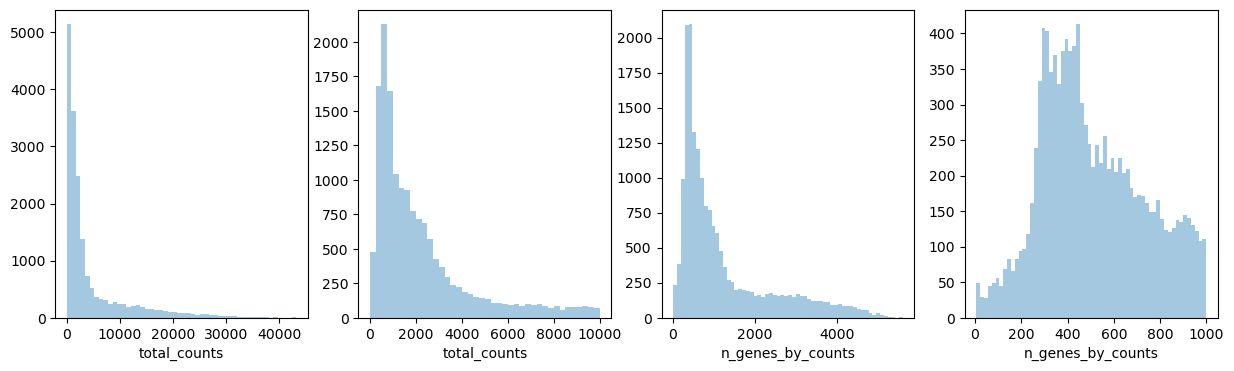

In [3]:
# filter out genes
sc.pp.filter_genes(adata, min_cells=200)
# Clean up data
sc.pp.calculate_qc_metrics(adata, inplace=True)
# Plot the raw data
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata.obs["total_counts"][adata.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 1000], kde=False, bins=60, ax=axs[3])

In [4]:
# Normalize genes count and log1p
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)

<AxesSubplot:>

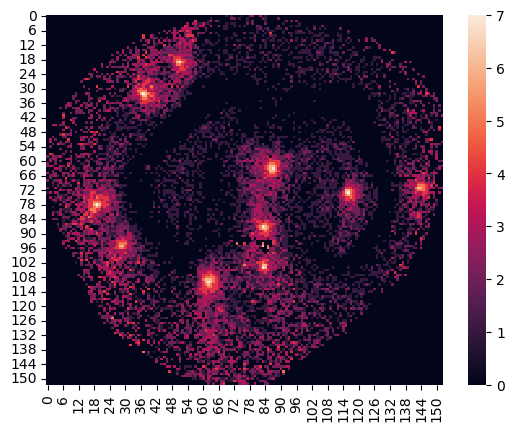

In [5]:
sns.heatmap(get_exp_array(adata, 'AMEX60DD000274'))

In [6]:
sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=2000)
gene_list = list(adata.var[adata.var['highly_variable']].index)

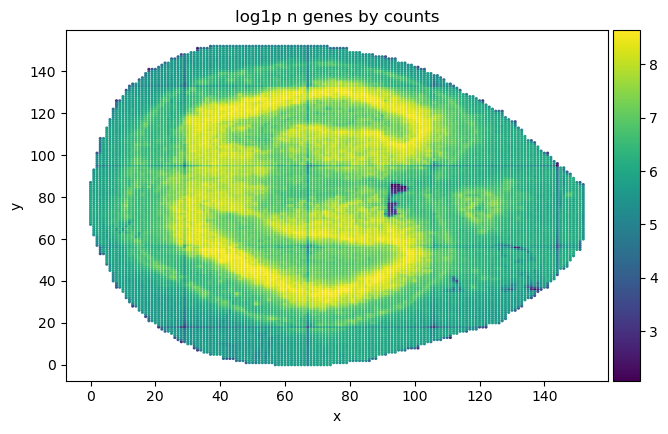

In [7]:
sc.pl.scatter(adata,
              x='x',
              y='y',
              color='log1p_n_genes_by_counts',
              size=20,
              palette=['#FF0000', '#00FF00', '#0000FF'])

<AxesSubplot:ylabel='Count'>

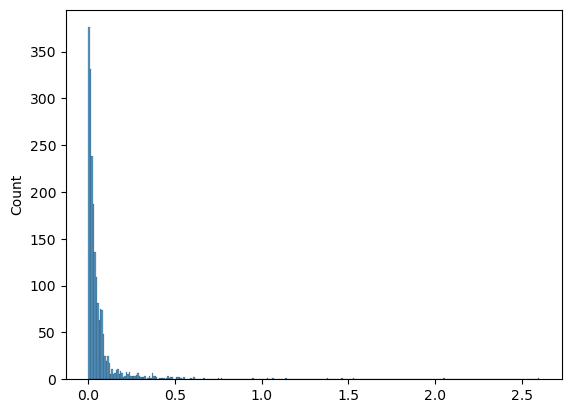

In [8]:
var = []
new_list = []
gene_list = list(adata.var[adata.var['highly_variable']].index)
for i in gene_list:
    v = np.var(get_exp_array(adata, i))
    var.append(v)
    if v > 0.1:
        new_list.append(i)
sns.histplot(var)

In [9]:
len(new_list)

261

In [10]:
gmm_dict = fit_gmms(adata, new_list, n_comp=20)

Fitting...: 100%|██████████| 261/261 [01:54<00:00,  2.28it/s]


In [133]:
new_dict = gmm_dict.copy()
for i in gmm_dict:
    top = sorted(gmm_dict[i].weights_, reverse=True)[:3]
    if sum(top) < 1/20 * 3 * 1.5:
        new_dict.pop(i)
len(new_dict.keys())
gmm_dict = new_dict

In [11]:
arr = build_gmm_distance_array(gmm_dict, method='optimized_match')

Building distance array...: 100%|██████████| 261/261 [04:13<00:00,  1.03it/s]


In [27]:
result = cluster(arr, n_clusters=7, mds_components=20, method='kmeans')

In [147]:
b = arr['AMEX60DD003014'].sort_values()
list(b.index[:8])

KeyError: 'AMEX60DD003014'

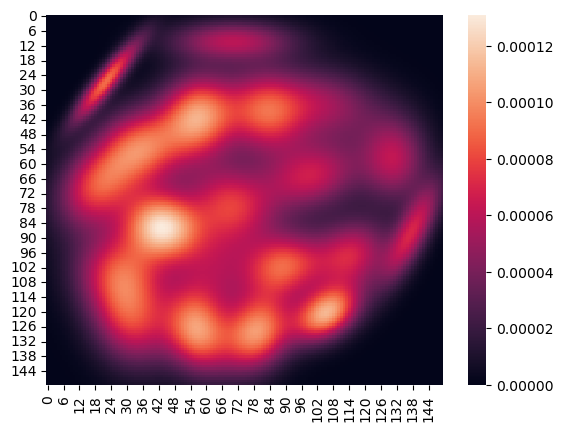

In [131]:
gmm = fit_gmm(adata, 'AMEX60DD012001', n_comp=20)
view_gmm(gmm,scope=(0,150))

In [137]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from palettable.colorbrewer.diverging import Spectral_11_r

li = list(result[result['labels'] == 5]['gene_id'])
new_colors = ['lightgrey', 'lightblue', '#00FF00', '#FFFF00', '#FFA500', '#FF0000']
new_cmap = colors.ListedColormap(new_colors)
num_plots = len(li)
num_cols = 4
num_rows = (num_plots + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 3 * num_rows))
fig.subplots_adjust(hspace=0.5)

for i, heatmap in enumerate(li):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    arr = get_exp_array(adata, heatmap)
    sns.heatmap(arr,
                cbar=False,
                ax=ax,
                cmap=new_cmap,
                vmax=np.percentile(arr, 99),
                # vmin=np.percentile(arr, 1)
                )
    ax.axis('off')
    ax.set_title(heatmap)

plt.tight_layout()
plt.show()


ValueError: Number of rows must be a positive integer, not 0

<Figure size 1200x0 with 0 Axes>

<AxesSubplot:>

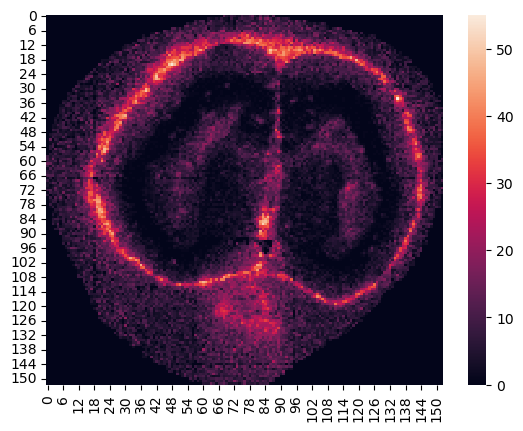

In [160]:
li = list(result[result['labels'] == 6]['gene_id'])
total = np.zeros(get_exp_array(adata, li[0]).shape)
for i in li:
    total += get_exp_array(adata, i)
sns.heatmap(total)